# Spotify Insights
note: The value of streams is NULL when the chart column is "viral50".

1. Carga de um conjunto de dados com um volume de dados adequado para o contexto da
disciplina (+1000 registros);
2. Realização do pré-processamento sobre o conjunto de dados;
3. A partir do conjunto resultante (pré-processado), estatísticas e visualizações devem ser
geradas para promover um entendimento inicial dos dados;
4. Com o conjunto de dados do item 3 aplique algum algoritmo de aprendizado de máquina,
apresente e discuta os resultados obtidos. Talvez seja necessário realizar transformações
para que os dados se adequem ao algoritmo escolhido.
A partir disso, cada equipe deve realizar uma apresentação discutindo todos os itens da
implementação (descrição e carga do conjunto de dados, pré-processamento realizado,
estatísticas e visualizações e, por fim, utilização de um algoritmo de aprendizado de máquina
com apresentação dos resultados).

##### Imports necessários

In [1]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
import pyspark.sql.functions as f
import pyspark.sql.types as t
import pandas as pd
import time


#### Carga de dados com um volume de dados adequado (+26M de registros);
O código abaixo cria o dataframe em chunks de tamanho 100000 para melhorar a performance da carga dos dados.


In [2]:
df = pd.read_csv("charts.csv", chunksize=100000)
a = pd.concat(df, ignore_index=True)
a.head(20)

,title,rank,date,artist,url,region,chart,trend,streams
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,Argentina,top200,SAME_POSITION,253019.0
1,Vente Pa' Ca (feat. Maluma),2,2017-01-01,Ricky Martin,https://open.spotify.com/track/7DM4BPaS7uofFul...,Argentina,top200,MOVE_UP,223988.0
2,Reggaetón Lento (Bailemos),3,2017-01-01,CNCO,https://open.spotify.com/track/3AEZUABDXNtecAO...,Argentina,top200,MOVE_DOWN,210943.0
3,Safari,4,2017-01-01,"J Balvin, Pharrell Williams, BIA, Sky",https://open.spotify.com/track/6rQSrBHf7HlZjtc...,Argentina,top200,SAME_POSITION,173865.0
4,Shaky Shaky,5,2017-01-01,Daddy Yankee,https://open.spotify.com/track/58IL315gMSTD37D...,Argentina,top200,MOVE_UP,153956.0
5,Traicionera,6,2017-01-01,Sebastian Yatra,https://open.spotify.com/track/5J1c3M4EldCfNxX...,Argentina,top200,MOVE_DOWN,151140.0
6,Cuando Se Pone a Bailar,7,2017-01-01,Rombai,https://open.spotify.com/track/1MpKZi1zTXpERKw...,Argentina,top200,MOVE_DOWN,148369.0
7,Otra vez (feat. J Balvin),8,2017-01-01,Zion & Lennox,https://open.spotify.com/track/3QwBODjSEzelZyV...,Argentina,top200,MOVE_DOWN,143004.0
8,La Bicicleta,9,2017-01-01,"Carlos Vives, Shakira",https://open.spotify.com/track/0sXvAOmXgjR2QUq...,Argentina,top200,MOVE_UP,126389.0
9,Dile Que Tu Me Quieres,10,2017-01-01,Ozuna,https://open.spotify.com/track/20ZAJdsKB5IGbGj...,Argentina,top200,MOVE_DOWN,112012.0


Backup de dados (apenas para desenvolvimento)

In [3]:
spotify_data = a
spotify_data.shape

(26173514, 9)

#### Pré-processamento de dados
O código abaixo realiza o pré-processamento dos dados, removendo as colunas que não serão utilizadas e removendo os registros que não possuem valor para a coluna streams.

Também é selecionado um determinado periodo de tempo, neste caso de primeiro de abril de 2020 até o dia 30 de abril de 2020.

In [4]:
start_date = '2020-04-01'
end_date = '2020-04-30'
mask = a['date'].between(start_date, end_date)
a = a.loc[mask]
a.shape

(461050, 9)

#### Remoção de caracteres especiais, mudança nos nomes definidos na coluna trend e eliminação de registros com valores nulos

In [5]:
import re
a = a.replace(re.compile(r'[^\w\s]+'), '', regex=True)
a['trend'] = a['trend'].replace('MOVE_DOWN', 0)
a['trend'] = a['trend'].replace('MOVE_UP', 1)
a['trend'] = a['trend'].replace('SAME_POSITION', 2)
a['trend'] = a['trend'].replace('NEW_ENTRY', 3)

missing = a.isna()
a = a.dropna()

##### Definição da região do Brasil

In [6]:

condition = (a['region'] == 'Brazil')
brazil = a.loc[condition]
# brazil = brazil.loc[brazil['artist'] == 'Gusttavo Lima']
brazil = brazil.sort_values(by=['rank'] , ascending=True)
brazil.head(5)

,title,rank,date,artist,url,region,chart,trend,streams
10408556,A Gente Fez Amor Ao Vivo,1,20200419,Gusttavo Lima,httpsopenspotifycomtrack3tv697PZNnaQN0Mn2zGhS5,Brazil,top200,2,614932.0
10244336,A Gente Fez Amor Ao Vivo,1,20200417,Gusttavo Lima,httpsopenspotifycomtrack3tv697PZNnaQN0Mn2zGhS5,Brazil,top200,2,647187.0
10488454,A Gente Fez Amor Ao Vivo,1,20200420,Gusttavo Lima,httpsopenspotifycomtrack3tv697PZNnaQN0Mn2zGhS5,Brazil,top200,2,522319.0
11536739,A Gente Fez Amor Ao Vivo,1,20200430,Gusttavo Lima,httpsopenspotifycomtrack3tv697PZNnaQN0Mn2zGhS5,Brazil,top200,2,620411.0
9033814,BRABA,1,20200403,Luísa Sonza,httpsopenspotifycomtrack2WlZuBDgLfT7Kc0admhFdg,Brazil,top200,2,698392.0


### Análise dos dados
#### Top 10 artistas com mais streams no mês de abril de 2020

                                 streams
artist                                  
Gusttavo Lima              614919.533333
Luísa Sonza                528899.833333
Henrique  Juliano          518292.466667
Dua Lipa                   493498.774194
Major Lazer MC Lan Anitta  423656.821429
Marília Mendonça           415126.228571
Matheus  Kauan             401261.333333
Jorge  Mateus              395673.230769
Vytinho NG                 381269.611111
Zé Neto  Cristiano         375756.500000


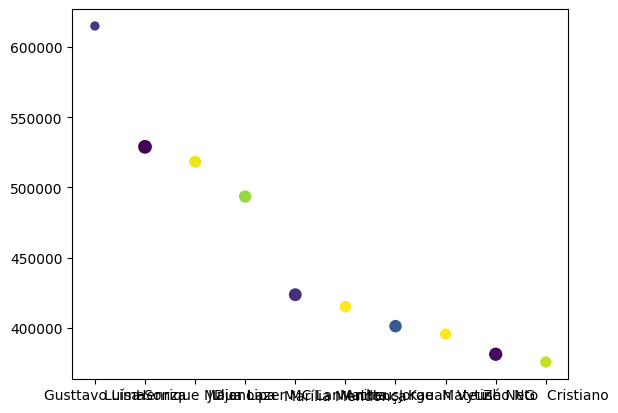

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import axes3d

brazil_top_10 = brazil.loc[brazil['rank'] <= 10]
brazil_top_10 = brazil_top_10.sort_values(by=['streams'] , ascending=False)
top10 = brazil_top_10.groupby('artist').mean()
top10.drop(['rank', 'trend'], axis=1, inplace=True)


top10 = top10.nlargest(10, 'streams')


print(top10)
y = top10['streams']
# z = brazil['rank']
X = top10.index
# plot
fig, ax = plt.subplots()
sizes = np.random.uniform(15, 80, len(X))
colors = np.random.uniform(15, 80, len(X))
ax.scatter(X, y, s=sizes, c=colors)

plt.show()
# z = np.array([z]).T
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(X, y, z)

### Word Cloud

In [15]:

from wordcloud import WordCloud

# create a word cloud object
wordcloud = WordCloud().generate_from_frequencies(top10.index, top10['streams'])

# display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt

AttributeError: 'Index' object has no attribute 'items'

In [ ]:
# condition = (brazil['artist'] == 'Luísa Sonza')
# brazil = brazil.loc[condition]

# y = brazil['streams']
# z = brazil['rank']
# X = brazil['trend']
# z = np.array([z]).T
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(X, y, z)

In [ ]:
import seaborn as sns

fig, axes = plt.subplots(figsize=(20,7))
sns.lineplot(x = 'date', y = 'streams', data=brazil, hue='title', ci=None).set_title('Trends in Top 200')

In [ ]:
fig, axes = plt.subplots(figsize=(20,7))
sns.lineplot(x = 'date', y = 'rank', data=brazil, hue='title', ci=None).set_title('Trends in Top 200')

In [ ]:
a['streams'].sort_values(ascending=False)

In [ ]:
spotify_data = spotify_data.filter(items=['streams'])
spotify_data.shape

### 


In [ ]:
# most streamed song in brazil 3D scatter(x, y, z) chart
from numpy import nan

datachart = df.filter(df.region == 'Brazil').groupBy('title', 'date').sum('streams').sort(f.col('sum(streams)').desc()).toPandas()
datachart['title'] = datachart['title'].replace('INTERE$$EIRA', 'interesseira')
datachart['sum(streams)'] = datachart['sum(streams)'].replace(nan, None)
datachart = datachart.dropna()

datachart

In [ ]:
# plt.scatter(x='title', y='sum(streams)', data= datachart)

In [ ]:
# from numpy import nan
# from plotly.offline import iplot
# import plotly.graph_objs as go
# import plotly.express as px

# datachart = df.filter(df.region == 'Brazil').groupBy('title', 'date').sum('streams').sort(f.col('sum(streams)').desc()).toPandas()
# datachart['title'] = datachart['title'].replace('INTERE$$EIRA', 'interesseira')
# datachart['sum(streams)'] = datachart['sum(streams)'].replace(nan, None)
# datachart = datachart.dropna()

# fig = px.scatter_3d(datachart, x='title', y='date', z='sum(streams)')
# fig.show()


### Algoritmo de classificação